## Application of Image Representation
Q: Time 도메인의 sound wave 를 Image와 같은 2-D Timestep-Frequency 도메인으로 나타냈을 때 어떤 장점들이 있을까?

A: **Vocal(Sound Source)-Isolation** 이라는 Task에 대해 매우 effective하게 사용할 수 있습니다.

### Vocal Isolation 이란?
음원이 있을때 Vocal(목소리)를 제외한 나머지 음원만 남기는 Process를 말합니다. 어떻게 목소리를 제거할 수 있을까요?

**기존 방법**: 목소리에 해당되는 음역대(Frequency)를 제거한다.

**기존 방법의 단점**: 목소리와 같은 배경음의 음역대도 함께 제거된다. 언제까지나 눈대중으로 하는 것이기 때문에 완벽하지 않다.

**AI를 만들줄 아는 우리들의 방법**: 목소리에 해당되는 음역대(Frequency)를 AI가 알아서 제거하게 한다.

In [1]:
# 수업자료 깃허브 Repository를 다운받아준다
!rm -rf ./NLP_2020
!git clone https://github.com/HanyangTechAI/NLP_2020.git
!rm -rf ./NLP_2020/.git

# 필요한 패키지 (인생을 편하게 해주는 미리 만들어놓은 프로그램이라고 보면 된다) 를 설치시킨다
!cat ./NLP_2020/lab02_sequence_meets_computer_vision/requirements.txt
!echo '----------------------------------'
!pip install -r ./NLP_2020/lab02_sequence_meets_computer_vision/requirements.txt

!pip install youtube_dl
!pip install pydub
!apt install ffmpeg

Cloning into 'NLP_2020'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 138 (delta 59), reused 106 (delta 30), pack-reused 0
Receiving objects: 100% (138/138), 2.02 MiB | 1.78 MiB/s, done.
Resolving deltas: 100% (59/59), done.
numpy
librosa
pandas
matplotlib
torch
torchvision
----------------------------------
/bin/sh: 1: pip: not found
/bin/sh: 1: pip: not found
/bin/sh: 1: pip: not found
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
The following packages were automatically installed and are no longer required:
  fonts-liberation2 fonts-opensymbol gir1.2-geocodeglib-1.0
  gir1.2-gst-plugins-base-1.0 gir1.2-gstreamer-1.0 gir1.2-gudev-1.0
  gir1.2-udisks-2.0 grilo-plugins-0.3-base gstreamer1.0-gtk3
  libboost-date-time1.65.1 libboost-filesystem1.65.1 libboost-iostrea

In [2]:
import youtube_dl

def download(link):
  ydl_opts = {
      'format': 'bestaudio/best',
      'postprocessors': [{
          'key': 'FFmpegExtractAudio',
          'preferredcodec': 'mp3',
          'preferredquality': '192',
      }],
  }
  with youtube_dl.YoutubeDL(ydl_opts) as ydl:
    result = ydl.extract_info(link,download=False)
    if 'entries' in result:
      video = result['entries'][0]
      return 0
    else:
      video = result
      title = "{}-{}.mp3".format(video["title"],video['id'])
      ydl.download([link])
      return title
    
link = input("유튜브 링크를 입력하시오: ")
file_path = download(link)
print('------------------------\n{} has been download'.format(file_path))

유튜브 링크를 입력하시오: https://www.youtube.com/watch?v=ex-ICeh8y9g
[youtube] ex-ICeh8y9g: Downloading webpage
[youtube] ex-ICeh8y9g: Downloading video info webpage
[youtube] ex-ICeh8y9g: Downloading webpage
[youtube] ex-ICeh8y9g: Downloading video info webpage
[download] Destination: Famous Last Words-ex-ICeh8y9g.webm
[download] 100% of 4.51MiB in 00:0010MiB/s ETA 00:007
[ffmpeg] Destination: Famous Last Words-ex-ICeh8y9g.mp3
Deleting original file Famous Last Words-ex-ICeh8y9g.webm (pass -k to keep)
------------------------
Famous Last Words-ex-ICeh8y9g.mp3 has been download


In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import tempfile
import os
import pydub
import scipy
import scipy.io.wavfile

def read_mp3(file_path, as_float = True):
    """
    Read an MP3 File into numpy data.
    :param file_path: String path to a file
    :param as_float: Cast data to float and normalize to [-1, 1]
    :return: Tuple(rate, data), where
        rate is an integer indicating samples/s
        data is an ndarray(n_samples, 2)[int16] if as_float = False
            otherwise ndarray(n_samples, 2)[float] in range [-1, 1]
    """

    path, ext = os.path.splitext(file_path)
    assert ext=='.mp3'
    mp3 = pydub.AudioSegment.from_mp3(file_path)
    _, path = tempfile.mkstemp()
    mp3.export(path, format="wav")
    rate, data = scipy.io.wavfile.read(path)
    os.remove(path)
    if as_float:
        data = data/(2**15)
    return rate, data

def plot(wave, sample_rate, start_sec, end_sec):
    start_index = int(float(start_second) * sample_rate)
    end_index = int(float(end_second) * sample_rate)
    
    plt.plot(wave[start_index:end_index])
    plt.ylabel('wave')
    plt.axis([None,None,-1,1])
    plt.show()

sample_rate, wave_data = read_mp3(file_path=file_path)
# Mono 오디오 파일로 변환
wave_data = wave_data.sum(axis=1) / 2

print('wave shape: {}'.format(wave_data.shape))
print('sample_rate: {}'.format(sample_rate))

wave shape: (14363192,)
sample_rate: 48000


### DeepIsolation API를 통해 학습된 모델을 Import 받아보자

In [4]:
import torch
import numpy as np
from tqdm import tqdm

import sys
sys.path.append("./DeepIsolation")

from DeepIsolation import API
from DeepIsolation.modules.util.stft import STFTConverter

api = API.Model(n_gpu=1)
model = api.getModel()

converter  = STFTConverter()

In [11]:
# 모델에 Spectrogram 전체를 집어넣으면 용량이 너무 크기 때문에
# segment로 잘라서 모델에 집어넣는 function 을 만들어준다

def isolate(wave, rate):
    # 10초 단위로 끊어 model 에 집어넣도록 하자
    interval_sec = 5
    length_sec = wave.shape[0] // rate  # 전체 길이 in seconds
    
    result = []
    for i in tqdm(range(length_sec//interval_sec), desc='Isolating MR'):
        start_sec = i * interval_sec  # 시작 초
        end_sec = (i+1) * interval_sec  # 끝 초
        
        start_tick = start_sec * rate  # 시작 tick index
        end_tick = end_sec * rate  # 끝 tick index
        
        # STFT 변환을 start_tick에서 end_tick 까지 해준다
        magnitude, phase = converter.get_stft(wave[start_tick:end_tick])
        
        # magnitude 를 pytorch Tensor로 변환해준다
        # shape: [batch_size(1), 1, time, freq]
        input_tensor = torch.FloatTensor(magnitude).to('cuda').unsqueeze(0).unsqueeze(0)
        
        # 모델에 집어넣어준다
        # output: [batch_size(1), 1, time, freq]
        estimated_magnitude = model(input_tensor)
        
        result.append(estimated_magnitude.cpu().detach().numpy()[0, 0, :, :])
    
    result = np.concatenate(result)
    return result

In [12]:
estimated_magnitude = isolate(wave_data, sample_rate)
print('estimated_magnitude shape: {}'.format(estimated_magnitude.shape))

Isolating MR: 100%|██████████| 59/59 [00:05<00:00, 10.96it/s]

estimated_magnitude shape: (13865, 2049)


In [14]:
original_magnitude, original_phase = converter.get_stft(wave_data)
# estimated magnitude 가 clipping 됨을 가만하여 길이를 estimated 와 맞춰주자
original_magnitude = original_magnitude[:estimated_magnitude.shape[0], :]
original_phase = original_phase[:estimated_magnitude.shape[0], :]

print('original_magnitude_shape: {}'.format(original_magnitude.shape))

original_magnitude_shape: (13865, 2049)


### Spectrogram이 어떻게 변화 했는지 알아보자

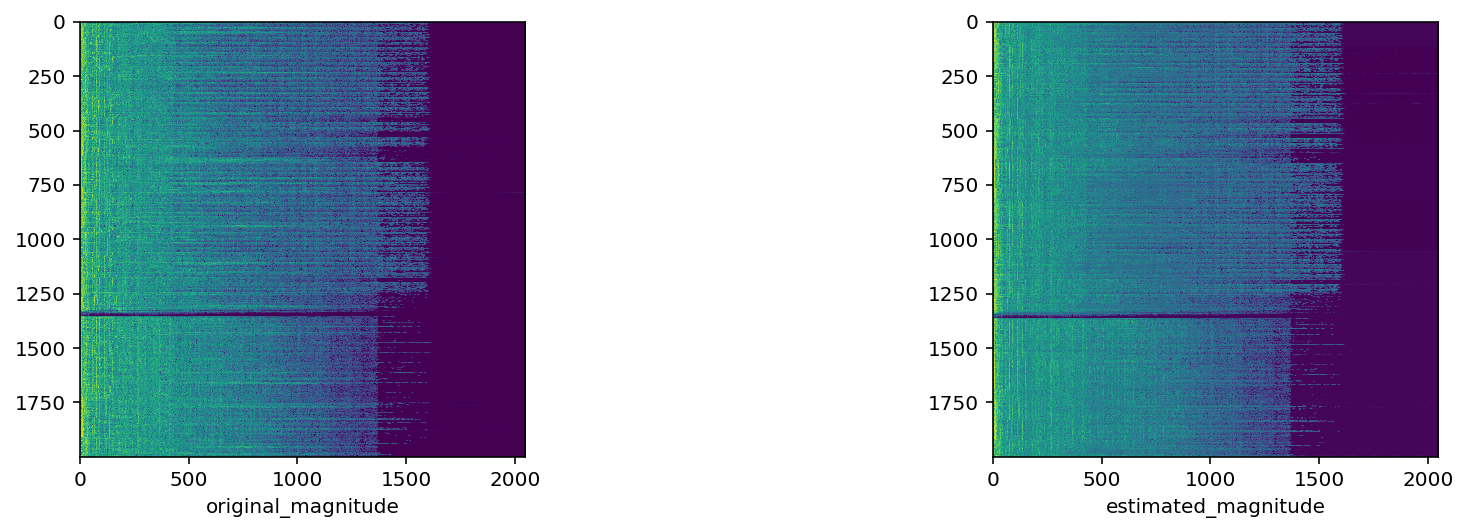

In [24]:
fig = plt.figure()
fig.set_figwidth(15)

plt.subplot(1,2,1)
plt.xlabel('original_magnitude')
plt.imshow(original_magnitude[2000:4000, :])

plt.subplot(1,2,2)
plt.xlabel('estimated_magnitude')
plt.imshow(estimated_magnitude[2000:4000, :])

plt.show()

In [33]:
generated_filter = estimated_magnitude / original_magnitude

In [35]:
np.max(generated_filter)

3995184.8